In [3]:

from mpdaf.obj import Cube
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy import units as u
from numpy import ma
import numpy as np
from astropy.table import Table, Column, MaskedColumn, pprint
from astropy.io import fits
from astropy.wcs import WCS
from mpdaf.obj import Image
from scipy import integrate

import matplotlib.pyplot as plt
import numpy as np

# Specify the path to your FITS file
fits_file = 'primer_cosmos_acswfc_f435w_30mas_sci.fits.gz'

# Open the FITS file
with fits.open(fits_file) as hdul:
    # Print the information about the FITS file
    hdul.info()
    
    # Get the primary header
    primary_header = hdul[0].header

    image_data = hdul[0].data

    # Get the WCS information
    wcs = WCS(primary_header)
    
    # Convert the header to an Astropy Table
    table_data = []
    for key, value in primary_header.items():
        table_data.append((key, value, primary_header.comments[key]))
    
    # Create the table
    table = Table(rows=table_data, names=('Key', 'Value', 'Comment'))
    print(table)
    print(image_data.shape)





Filename: primer_cosmos_acswfc_f435w_30mas_sci.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    6152   (26000, 44100)   float32   
  1  HDRTAB        1 BinTableHDU    633   316R x 312C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 23A, D, D, D, D, K, K, K, 8A, K, 23A, 9A, 20A, K, 4A, K, D, K, K, K, K, 23A, D, D, D, D, K, K, 3A, 3A, 4A, 7A, L, D, D, D, 23A, 1A, K, D, D, D, 13A, 3A, 4A, 4A, 12A, 12A, 23A, 8A, 23A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 23A, D, K, D, 11A, 9A, 8A, D, D, L, 9A, 18A, 3A, K, 7A, 5A, 3A, D, 13A, 8A, 4A, 3A, L, K, L, K, L, K, K, D, D, D, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, 23A, L, 1A, 3A, 6A, D, 3A, 6A, K, D, D, D, D, D, D, D, D, D, D, 23A, D, D, D, D, 3A, D, D, D, 1A, K, K, K, K, K, K, 23A, K, 5A, 7A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 13A, D, 24A, 23A, D, 2A, 8A, D, K, D, D, 6A, 13A, D, 20A, K, D

In [4]:
table


Key,Value,Comment
str12,object,str50
SIMPLE,True,conforms to FITS standard
BITPIX,-32,array data type
NAXIS,2,number of array dimensions
NAXIS1,26000,
NAXIS2,44100,
EXTEND,True,
COMMENT,FITS (Flexible Image Transport System) format is defined in 'Astronomy,
COMMENT,"and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H",
,,


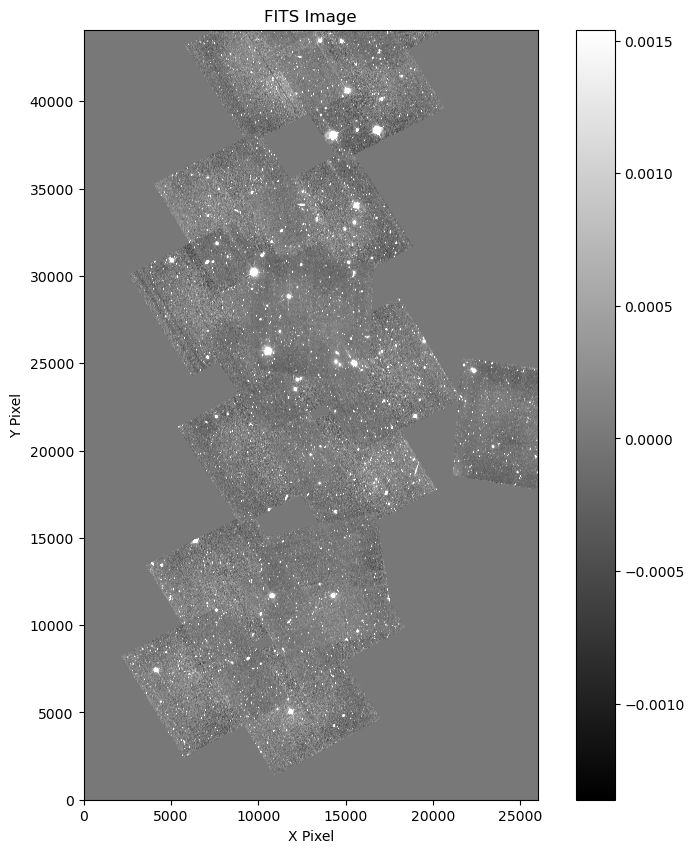

In [2]:


# Compute the percentiles to adjust contrast
vmin = np.percentile(image_data, 5)
vmax = np.percentile(image_data, 95)

# Display the image data
plt.figure(figsize=(10, 10))
plt.imshow(image_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('FITS Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()


In [3]:
# Replace all 0.0 values with NaN
im_array = np.where((image_data == 0.0), np.nan, image_data)



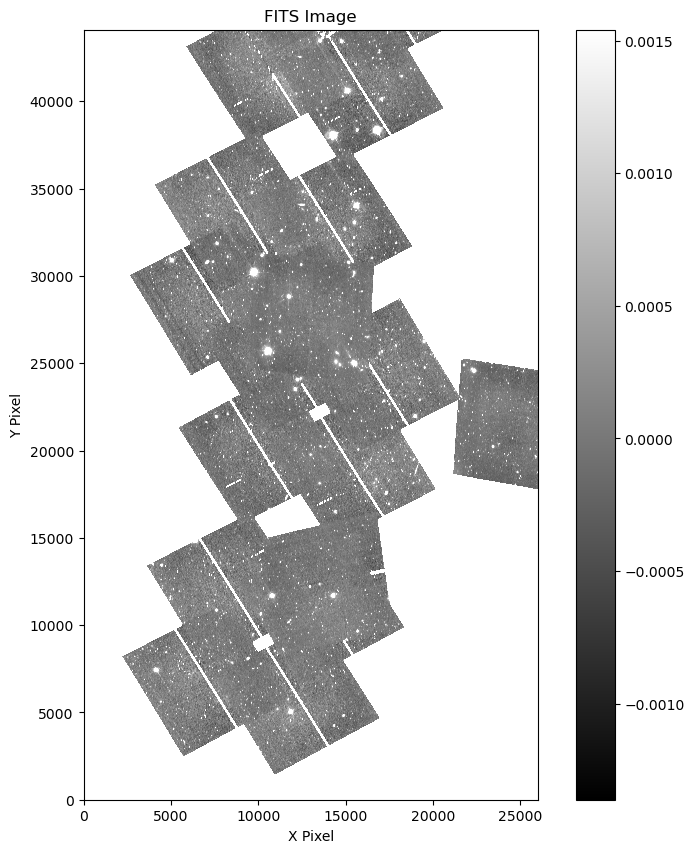

In [4]:
# Display the image data
plt.figure(figsize=(10, 10))
plt.imshow(im_array, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('FITS Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()


In [5]:
from photutils.datasets import make_100gaussians_image
data = im_array
print (data)

# maybe the background substraction is the problem -is this provided in muse?
from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()
bkg = Background2D(data, (30,30), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
data -= bkg.background  # subtract the background

threshold = 2 * bkg.background_rms

from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
convolved_data = convolve(data, kernel)

from photutils.segmentation import detect_sources
segment_map = detect_sources(convolved_data, threshold, npixels=5)
print(segment_map)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


<photutils.segmentation.core.SegmentationImage>
shape: (44100, 26000)
nlabels: 30838
labels: [    1     2     3     4     5 ... 30834 30835 30836 30837 30838]


Text(0.5, 1.0, 'Segmentation Image')

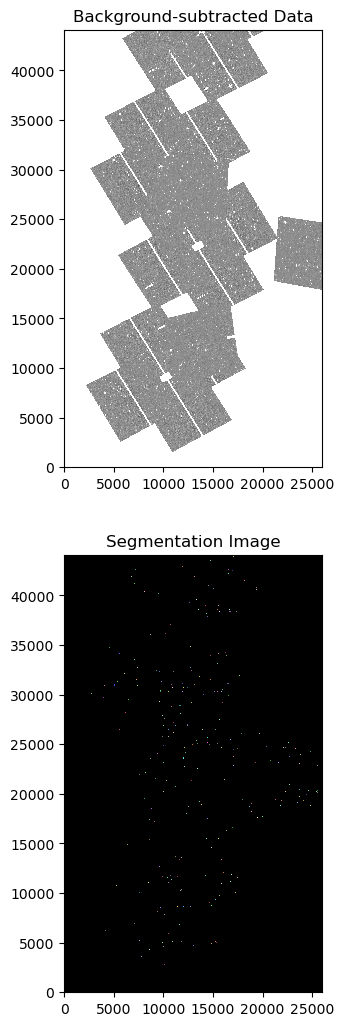

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', vmin=vmin, vmax=vmax,)
ax1.set_title('Background-subtracted Data')
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')


In [7]:
from photutils.segmentation import deblend_sources
segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels=10, nlevels=32, contrast=0.001,
                               progress_bar=False)

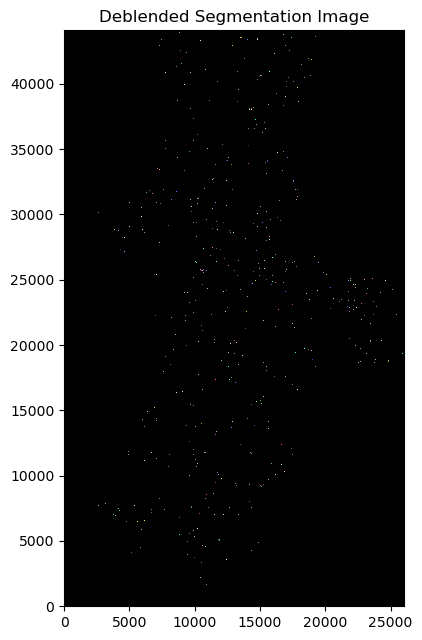

In [8]:
norm = ImageNormalize(stretch=SqrtStretch())
fig, ax = plt.subplots(1, 1, figsize=(10, 6.5))
ax.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,
          interpolation='nearest')
ax.set_title('Deblended Segmentation Image')
plt.tight_layout()


In [9]:
from photutils.segmentation import SourceFinder
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(convolved_data, threshold)
print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (44100, 26000)
nlabels: 27099
labels: [    1     2     3     4     5 ... 27095 27096 27097 27098 27099]


In [10]:
from photutils.segmentation import SourceFinder
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(convolved_data, threshold)
print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (44100, 26000)
nlabels: 27099
labels: [    1     2     3     4     5 ... 27095 27096 27097 27098 27099]


In [11]:
from photutils.segmentation import SourceCatalog
cat = SourceCatalog(data, segm_deblend, convolved_data=convolved_data)
print(cat)

<photutils.segmentation.catalog.SourceCatalog>
Length: 35414
labels: [    1     2     3     4     5 ... 35410 35411 35412 35413 35414]


In [12]:
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['kron_flux'].info.format = '.2f'
print(tbl)

label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
----- --------- --------- ... --------------- --------- ------------
    1  10911.64   1398.00 ...             nan      0.11          nan
    2  10937.03   1394.62 ...             nan      0.02          nan
    3  10956.70   1404.79 ...             nan       nan          nan
    4  10981.10   1418.67 ...             nan      0.02          nan
    5  10986.13   1420.80 ...             nan      0.03          nan
    6  10996.50   1427.52 ...             nan      0.05          nan
    7  11008.43   1432.69 ...             nan       nan          nan
    8  10887.94   1437.35 ...             nan      0.02          nan
    9  11046.78   1457.40 ...             nan      0.05          nan
   10  11075.55   1469.77 ...             nan      0.03          nan
  ...       ...       ... ...             ...       ...          ...
35405  13293.73  44019.05 ...     

 ...]

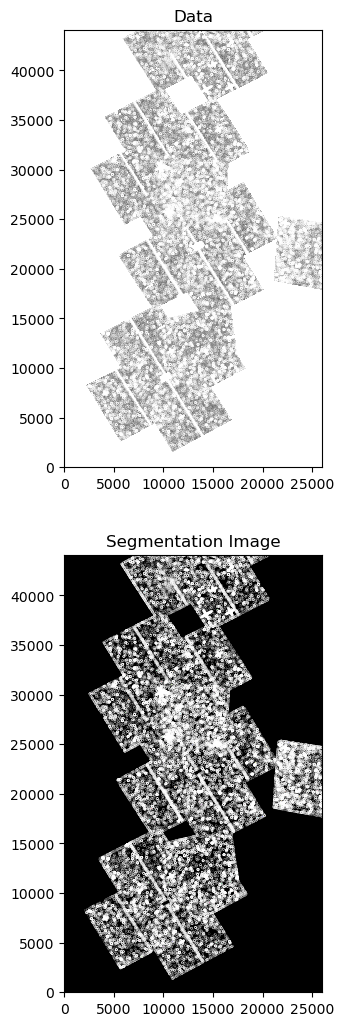

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', vmin=vmin, vmax=vmax)
ax1.set_title('Data')
ax2.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')
cat.plot_kron_apertures(ax=ax1, color='white', lw=1.5)
cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5)

In [17]:
cat = SourceCatalog(data, segm_deblend, convolved_data=convolved_data)
labels = [1, 5, 20, 50, 75, 80]
cat_subset = cat.get_labels(labels)
tbl2 = cat_subset.to_table()
tbl2['xcentroid'].info.format = '.2f'  # optional format
tbl2['ycentroid'].info.format = '.2f'
tbl2['kron_flux'].info.format = '.2f'
print(tbl2)

label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
----- --------- --------- ... --------------- --------- ------------
    1  10911.64   1398.00 ...             nan      0.11          nan
    5  10986.13   1420.80 ...             nan      0.03          nan
   20  11315.74   1599.59 ...             nan      0.03          nan
   50  10599.30   1914.02 ...             nan       nan          nan
   75  10548.88   2105.23 ...             nan      0.22          nan
   80  11148.11   2173.06 ...             nan      2.10          nan


In [18]:
cat = SourceCatalog(data, segm_deblend, convolved_data=convolved_data)
labels = [1, 5, 20, 50, 75, 80]
cat_subset = cat.get_labels(labels)
columns = ['label', 'xcentroid', 'ycentroid', 'area', 'segment_flux']
tbl3 = cat_subset.to_table(columns=columns)
tbl3['xcentroid'].info.format = '.4f'  # optional format
tbl3['ycentroid'].info.format = '.4f'
tbl3['segment_flux'].info.format = '.4f'
print(tbl3)

label xcentroid  ycentroid  area segment_flux
                            pix2             
----- ---------- --------- ----- ------------
    1 10911.6438 1397.9993  10.0       0.0328
    5 10986.1263 1420.8034   1.0       0.0053
   20 11315.7425 1599.5888   1.0       0.0035
   50 10599.2967 1914.0192   nan          nan
   75 10548.8756 2105.2298  22.0       0.0781
   80 11148.1125 2173.0586 120.0       1.9860


In [19]:
cat = SourceCatalog(data, segm_deblend, background=bkg.background)
labels = [1, 5, 20, 50, 75, 80]
cat_subset = cat.get_labels(labels)
columns = ['label', 'background_centroid', 'background_mean',
           'background_sum']
tbl4 = cat_subset.to_table(columns=columns)
tbl4['background_centroid'].info.format = '{:.10f}'  # optional format
tbl4['background_mean'].info.format = '{:.10f}'
tbl4['background_sum'].info.format = '{:.10f}'
print(tbl4)

label background_centroid background_mean background_sum
----- ------------------- --------------- --------------
    1        0.0001153829    0.0000154658   0.0001546580
    5        0.0001261061    0.0000239581   0.0000239581
   20        0.0002282042   -0.0000219517  -0.0000219517
   50                 nan             nan            nan
   75        0.0000565150    0.0002123590   0.0046718981
   80        0.0003744519    0.0001041249   0.0124949840


In [20]:
from photutils.utils import calc_total_error
effective_gain = 500.0
error = calc_total_error(data, bkg.background_rms, effective_gain)
cat = SourceCatalog(data, segm_deblend, error=error)
labels = [1, 5, 20, 50, 75, 80]
cat_subset = cat.get_labels(labels)  # select a subset of objects
columns = ['label', 'xcentroid', 'ycentroid', 'segment_flux',
           'segment_fluxerr']
tbl5 = cat_subset.to_table(columns=columns)
tbl5['xcentroid'].info.format = '{:.4f}'  # optional format
tbl5['ycentroid'].info.format = '{:.4f}'
tbl5['segment_flux'].info.format = '{:.4f}'
tbl5['segment_fluxerr'].info.format = '{:.4f}'
for col in tbl5.colnames:
    tbl5[col].info.format = '%.8g'  # for consistent table output
print(tbl5)

: 

# As Functions

In [77]:
# Imports necessary for Source Catalog
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from photutils.segmentation import SourceFinder
from photutils.segmentation import SourceCatalog
from scipy.ndimage import binary_erosion

# Imports necessary for visulisation
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import simple_norm

In [92]:
from numpy import savetxt
im26_data = im26.data
# save to csv file
savetxt('im26_data.csv', im26_data, delimiter=',')


# load numpy array from csv file
from numpy import loadtxt
im26_data1 = loadtxt('im26_data.csv', delimiter=',')

print(im26_data.shape)
print(im26_data1.shape)


(411, 409)
(411, 409)


In [95]:


def source_catalog(data, npixels=10):


    """  

    Takes an image from the mpdaf bandpass_image function 
    (a 2d image convolved with a bandpass filter) and returns a source catalog
    of the sources in the image. 

    Parameters
    ----------
    data : np.ndarray
        The data array of the image

    npixels : int
        The number of pixels that define the minimum source size. Default is 10.

    Returns
    -------
    data : np.ndarray
        The data array of the image

    tbl : astropy.table.Table
        A table containing the source catalog

    segment_map : np.ndarray
        The segmentation map of the image

    segm_deblend : np.ndarray
        The deblended segmentation map of the image

    cat : photutils.segmentation.SourceCatalog
        The source catalog of the image


    """

    
    # Replace all 0.0 values with NaN
    data = np.where((data == 0.0), np.nan, data)


    data_e = ndimage.binary_erosion(data, iterations=25)

    data = np.where(data_e == False, np.nan, data)

    

    
    # Background substraction
    bkg_estimator = MedianBackground()
    bkg = Background2D(data, (30, 30), filter_size=(3, 3),
                    bkg_estimator=bkg_estimator)
    data -= bkg.background  # subtract the background

    # Select threshold above background at x-sigma  pixel noise level
    threshold = 2 * bkg.background_rms

    # Convolve the data with a 2d gaussian kernel
    kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
    convolved_data = convolve(data, kernel)

    # Detect sources in the convolved data
    segment_map = detect_sources(convolved_data, threshold, npixels) # Should all the npixels be the same?
    
    # Deblend the sources
    segm_deblend = deblend_sources(convolved_data, segment_map,
                                npixels, nlevels=32, contrast=0.001,
                                progress_bar=False)

    # Find the sources
    finder = SourceFinder(npixels, progress_bar=False)
    segment_map = finder(convolved_data, threshold)

    # Create a source catalog
    cat = SourceCatalog(data, segm_deblend, convolved_data=convolved_data)
    
    # Create a table of the source catalog
    tbl = cat.to_table()
    tbl['xcentroid'].info.format = '.2f'  # optional format
    tbl['ycentroid'].info.format = '.2f'
    tbl['kron_flux'].info.format = '.2f'

    
    return data, tbl, segment_map, segm_deblend, cat 




def visulisation(segment_map, data, segm_deblend, cat):

    """
    Generates plots of the data, segmentation map and deblended segmentation map
    of the sources in the image. It also plots the sources selected in the source catalog.  
    
    This gives the visulisation of the sources selected so the selection critieria can be adjusted by eye.

    Parameters
    ----------
    segment_map : np.ndarray
        The segmentation map of the image

    data : np.ndarray   
        The data array of the image
    
    segm_deblend : np.ndarray       
        The deblended segmentation map of the image

    cat : photutils.segmentation.SourceCatalog
        The source catalog of the image
    
    Returns
    -------
    plt.show() : matplotlib.pyplot
        The plots of the data, segmentation map and deblended segmentation map of the sources in the image


    """
    
    norm = ImageNormalize(stretch=SqrtStretch())
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
    ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
    ax1.set_title('Background-subtracted Data')
    ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
               interpolation='nearest')
    ax2.set_title('Segmentation Image')

    norm = ImageNormalize(stretch=SqrtStretch())
    fig, ax = plt.subplots(1, 1, figsize=(10, 6.5))
    ax.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,
              interpolation='nearest')
    ax.set_title('Deblended Segmentation Image')
    plt.tight_layout()

    norm = simple_norm(data, 'sqrt')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
    ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
    ax1.set_title('Data')
    ax2.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,
               interpolation='nearest')
    ax2.set_title('Segmentation Image')
    cat.plot_kron_apertures(ax=ax1, color='white', lw=1.5)
    cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5)

    return plt.show()

In [96]:
# Image produced at the top of the script from the bandpass_image function
source_catalog(im26_data1,10)[1]


label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,103.17,24.67,None,100,106,23,27,17.0,1.7627380505116639,1.2628635876914447,18.54184350040991,0.6976676234912447,0.10767548870421795,1.1699728984037647,0.0,10.806436234466199,nan,12.90,nan
2,135.66,60.79,None,133,139,55,66,49.0,3.251034819253241,1.2585797565442751,-70.86299014424976,0.9220242838816161,0.17970133207235475,0.4804530455860192,0.0,17.162783772382074,nan,67.09,nan
3,227.86,61.57,None,223,232,56,68,106.0,2.718430456560337,1.941598646229823,-79.81483184767399,0.699905792432268,0.17566870321331868,5.31610991347356,0.0,151.3620061649507,nan,158.34,nan
4,144.56,65.27,None,140,149,63,67,31.0,2.63717051669338,0.9277912320694449,19.11298332209713,0.9360702520061623,0.18889025017250952,0.5030725065123121,0.0,10.637891032201573,nan,113.62,nan
5,183.51,75.48,None,181,186,71,79,43.0,2.3007129124874908,1.4729025410272771,-86.52163794481154,0.7682133014089955,0.205257757522394,0.4864899561383778,0.0,15.587609821987948,nan,115.22,nan
6,137.86,74.56,None,134,143,72,77,45.0,2.4740323898633534,1.3527652901455984,20.96604132381765,0.8372726588336571,0.21296179987577527,0.5882450837542776,0.0,16.965169423072638,nan,90.78,nan
7,244.12,78.74,None,239,249,75,83,70.0,2.3474290007959278,1.8272772172372025,28.375906465340407,0.6277482919438526,0.21822457397699035,1.5695219749810099,0.0,53.0816024977015,nan,60.89,nan
8,231.85,89.87,None,229,235,87,93,35.0,1.603996393386561,1.5001451539253163,-45.74937770374968,0.35397550742458583,0.24754352931160933,1.0595124150974888,0.0,19.176252794188542,nan,43.10,nan


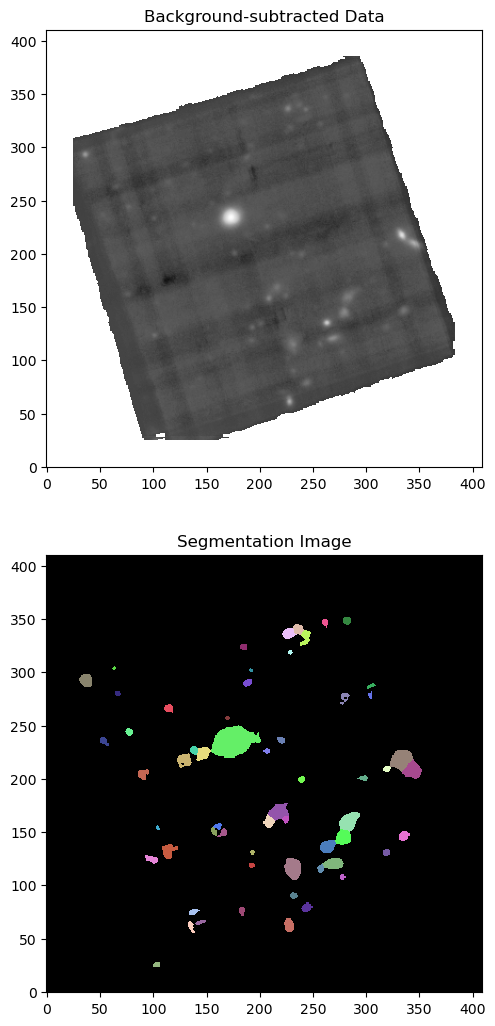

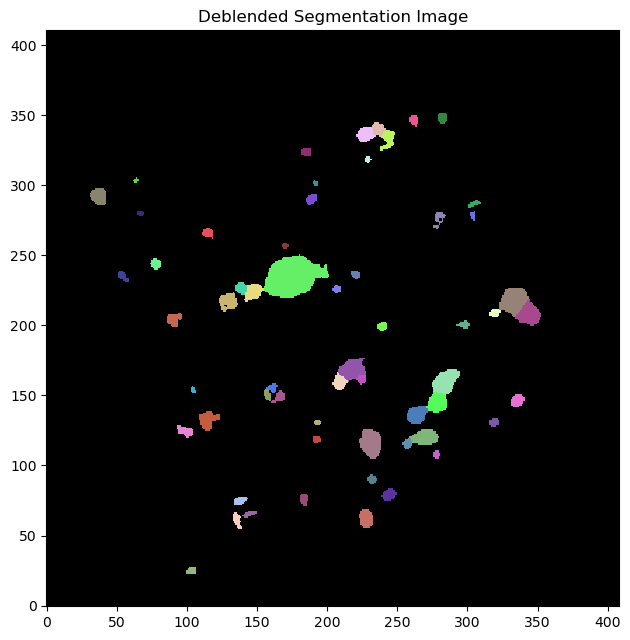

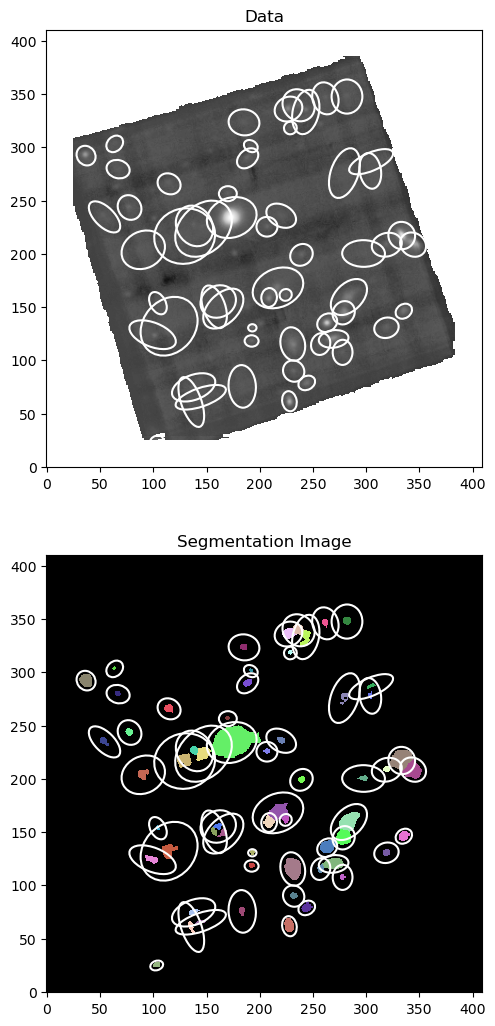

In [98]:
data, tbl, segment_map, segm_deblend, cat = source_catalog(im26_data1,10)
visulisation(segment_map, data, segm_deblend, cat)


# the botttom plot seems to not change when the source catalog is changed 

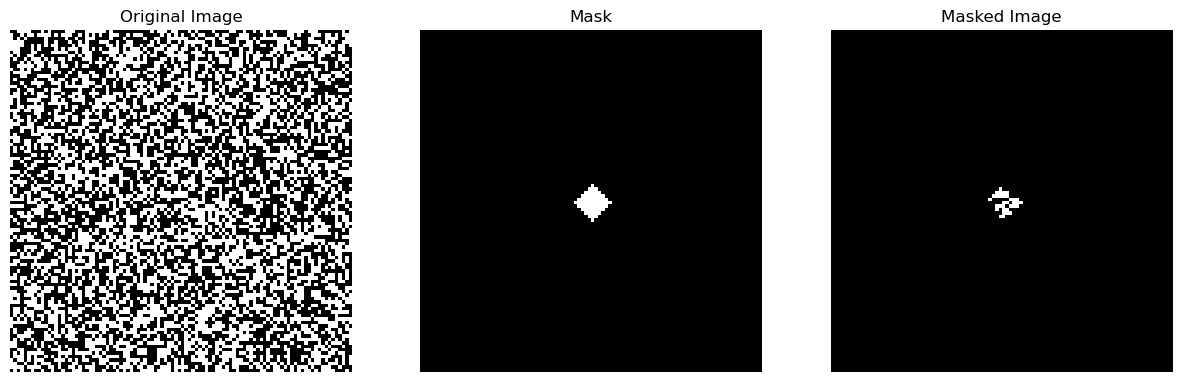

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Define the large triangular structuring element
large_structuring_element = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                      [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                                      [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
                                      [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                                      [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                                      [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                                      [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                                      [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
                                      [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                                      [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

# Create a dummy image for demonstration (e.g., an image of size 100x100)
image = np.random.randint(0, 2, size=(100, 100), dtype=int)

# Determine the center of the image
image_center = (image.shape[0] // 2, image.shape[1] // 2)

# Determine the offsets for placing the structuring element at the center of the image
offsets = (large_structuring_element.shape[0] // 2, large_structuring_element.shape[1] // 2)

# Create a mask of the same size as the image, initialized to zeros
mask = np.zeros_like(image)

# Place the structuring element at the center of the mask
mask[image_center[0] - offsets[0]:image_center[0] + offsets[0] + 1,
     image_center[1] - offsets[1]:image_center[1] + offsets[1] + 1] = large_structuring_element

# Apply the mask to the image
masked_image = image * mask

# Visualize the original image, the mask, and the masked image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Masked Image')
plt.imshow(masked_image, cmap='gray')
plt.axis('off')

plt.show()



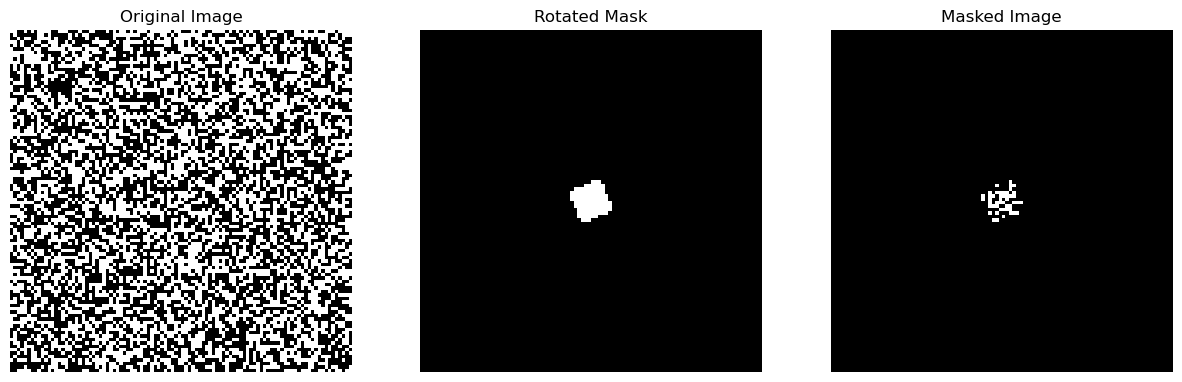

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# Define a square structuring element
square_size = 11  # Size of the square
square_structuring_element = np.ones((square_size, square_size), dtype=int)

# Rotate the square by 40 degrees
rotated_square = rotate(square_structuring_element, angle=20, reshape=True, order=1)

# Binarize the rotated square (values will be between 0 and 1 due to rotation interpolation)
rotated_square = rotated_square > 0.5

# Create a dummy image for demonstration (e.g., an image of size 100x100)
image = np.random.randint(0, 2, size=(100, 100), dtype=int)

# Determine the center of the image
image_center = (image.shape[0] // 2, image.shape[1] // 2)

# Determine the offsets for placing the structuring element at the center of the image
offsets = (rotated_square.shape[0] // 2, rotated_square.shape[1] // 2)

# Create a mask of the same size as the image, initialized to zeros
mask = np.zeros_like(image)

# Place the structuring element at the center of the mask
mask[image_center[0] - offsets[0]:image_center[0] + offsets[0],
     image_center[1] - offsets[1]:image_center[1] + offsets[1]] = rotated_square
# Apply the mask to the image
masked_image = image * mask

# Visualize the original image, the mask, and the masked image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Rotated Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Masked Image')
plt.imshow(masked_image, cmap='gray')
plt.axis('off')

plt.show()

